## Plot Wflow results

**hydroMT** provides a simple interface to model results from which we can make beautiful plots:

- Results layers are saved to the model `results` attribute as a dictionnary of `xarray.Dataset` or `xarray.DataArray`.

These plots can be useful to analyze the model results or also compare model runs with different settings (different precipitation source or different parameters values).

### Load dependencies

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from os.path import join, dirname
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

In [2]:
import hydromt

### Read the model run(s) results

The **wflow_piave_subbasin** model was run using the default global data sources of the hydromt_wflow plugin. The different variables to save after the wflow were set in a separate wflow configuration file: *wflow_sbm_results.toml*.

A second run of the model was also done, where the KsatHorFrac parameter of wflow was set to 10 (instead of the default 100 value) using an alternative configuration file: *wflow_sbm_results2.toml*.

We will use the below `runs` dictionnary to define the model run(s) we want to read and some settings for plotting. If you want to plot and compare several runs together, you can simply add them to the `runs` dictionnary.

In [3]:
# Dictionnary listing the different wflow models and runs to compare, including plotting options
runs = {
    "run1": {
        "longname": "default",
        "color": "blue",
        "root": "wflow_piave_subbasin",
        "config_fn": "wflow_sbm_results.toml",
    },
    "run2": {
        "longname": "KsatHorFrac10",
        "color": "green",
        "root": "wflow_piave_subbasin",
        "config_fn": "wflow_sbm_results2.toml",
    },
}
mainrun = "run1"

In [4]:
# Initialize the different model run(s)
for r in runs:
    run = runs[r]
    mod = hydromt.WflowModel(root=run["root"], mode="r+", config_fn=run["config_fn"])
    runs[r].update({"mod": mod})

Wflow can save different types of outputs (netcdf gridded output, netcdf scalar netcdf, csv scalar timeseries) that are also reflected in the organisation of the hydroMT `results` attribute:

* a **"output" xarray.Dataset** for the gridded netcdf file (output section of the TOML)
* a **"netcdf" xarray.Dataset** for the netcdf point timeseries file (netcdf section of the TOML)
* different **hydromt.GeoDataArrays for the csv file** , one per column (csv section and csv.column sections of the TOML). The xy coordinates are the coordinates of the station or of the representative point of the subcatch/area. The variable name in the GeoDataArray corresponds to the csv header attribute or header_map when available.

Below you can see how to access to the results of *run1* and its contents:

In [5]:
mod1 = runs["run1"]["mod"]
mod1.results

{'output': <xarray.Dataset>
 Dimensions:  (lon: 58, lat: 53, layer: 4, time: 9)
 Coordinates:
   * lon      (lon) float64 11.78 11.8 11.82 11.83 ... 12.68 12.7 12.72 12.73
   * lat      (lat) float64 45.82 45.83 45.85 45.87 ... 46.63 46.65 46.67 46.68
   * layer    (layer) int64 1 2 3 4
   * time     (time) datetime64[ns] 2010-02-02 2010-02-03 ... 2010-02-10
 Data variables:
     q_river  (time, lat, lon) float32 dask.array<chunksize=(9, 53, 58), meta=np.ndarray>
     h_land   (time, lat, lon) float32 dask.array<chunksize=(9, 53, 58), meta=np.ndarray>,
 'netcdf': <xarray.Dataset>
 Dimensions:       (time: 9, Q_gauges: 1, temp_bycoord: 1)
 Coordinates:
   * time          (time) datetime64[ns] 2010-02-02 2010-02-03 ... 2010-02-10
   * Q_gauges      (Q_gauges) object '1'
   * temp_bycoord  (temp_bycoord) object 'temp_bycoord'
 Data variables:
     Q             (time, Q_gauges) float32 dask.array<chunksize=(9, 1), meta=np.ndarray>
     temp_coord    (time, temp_bycoord) float32 dask.array

### Read observations

You can also use hydroMT to read observations data in order to analyze your model results.
Here a **fictional** observations timeseries was prepared for the gauges_grdc locations. 

In [6]:
# Discharge data
timeseries_fn = "gauges_observed_flow.csv"  # observed discharge timeseries
name = "gauges_grdc"  # gauges locations in staticgeoms
stationID = "grdc_no"  # column name in staticgeoms containing the stations IDs

# Read the observations data
# read timeseries data and match with existing gdf
gdf = runs[mainrun]["mod"].staticgeoms[name]
gdf.index = gdf[stationID]
da_ts = hydromt.io.open_timeseries_from_table(timeseries_fn, name=name, sep=";")
da = hydromt.vector.GeoDataArray.from_gdf(gdf, da_ts, index_dim="index")

obs = da
obs

<xarray.DataArray 'gauges_grdc' (index: 3, time: 9)>
array([[14.21117463, 20.63727294, 26.21875575, 29.66606831, 32.1589512 ,
        32.26008825, 31.09006663, 29.99882382, 29.10063939],
       [23.14968045, 40.4367125 , 54.46918112, 59.2240498 , 59.21861451,
        57.43010672, 54.0491823 , 50.84542554, 48.09354881],
       [ 4.65726064,  9.23746886, 11.94857033, 12.4642965 , 11.93064957,
        11.23056571, 10.51420303,  9.88308009,  9.31225629]])
Coordinates: (12/27)
  * index          (index) int64 6349410 6349400 6349411
  * time           (time) datetime64[ns] 2010-02-02 2010-02-03 ... 2010-02-10
    x              (index) float64 12.22 12.52 12.12
    y              (index) float64 46.43 46.53 46.6
    d_end          (index) int64 2008 2008 2008
    d_miss         (index) float64 36.77 33.53 51.14
    ...             ...
    t_end          (index) int64 2008 2008 2008
    grdc_no        (index) int64 6349410 6349400 6349411
    country        (index) object 'IT' 'IT' 'IT'
    t_start        (index) int64 1930 1932 1943
    d_yrs          (index) int64 79 77 66
    spatial_ref    int64 1

### Plot model results

Here we plot the different model results for the gauges_grdc locations.

In [7]:
# Plotting options
# select the gauges_grdc results (name in csv column of wflow results to plot)
result_name = "Q_gauges_grdc"

# selection of runs to plot (all or a subset)
runs_subset = ["run1", "run2"]

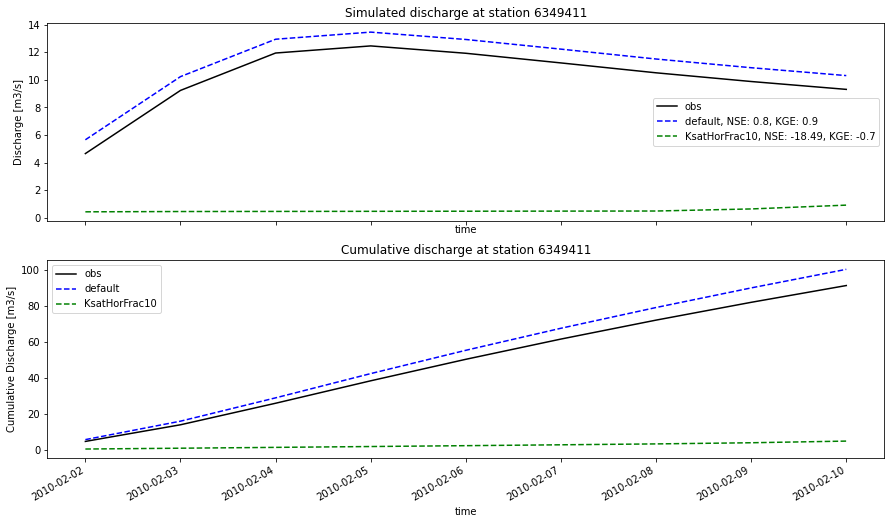

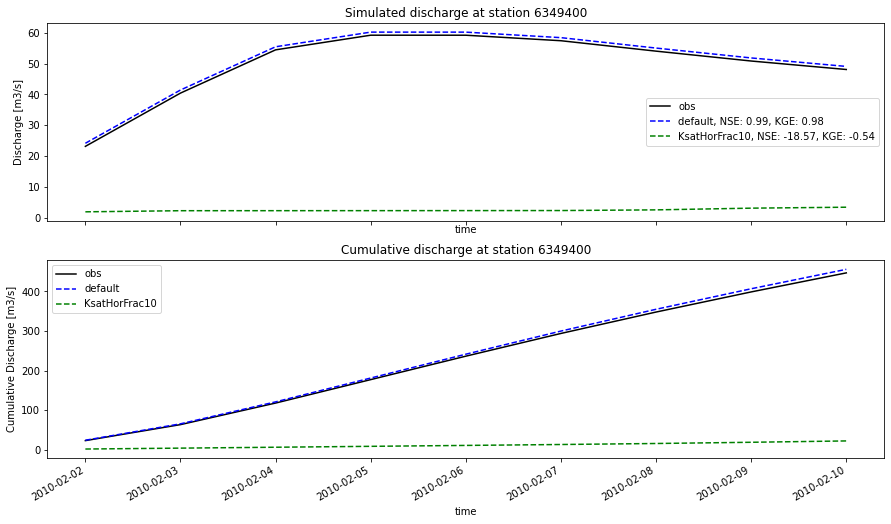

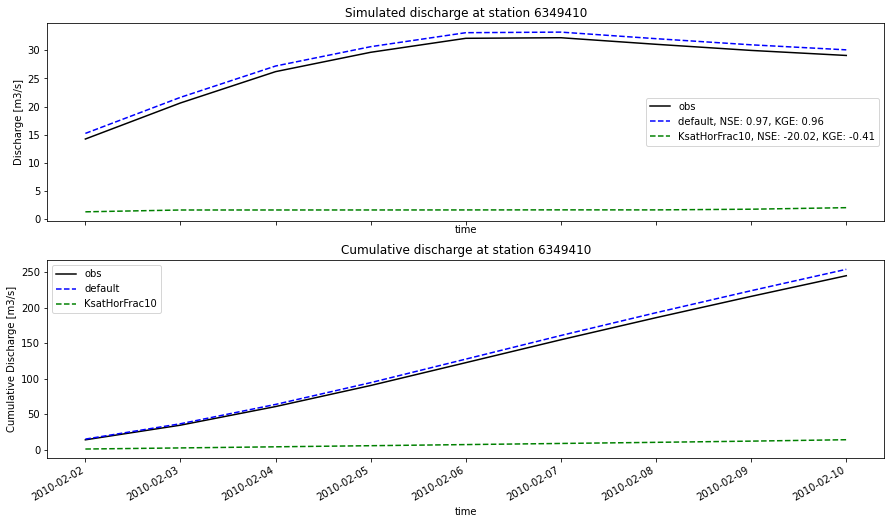

In [8]:
# Plots
station_ids = list(runs[mainrun]["mod"].results[result_name].index.values)

for i, st in enumerate(station_ids):
    n = 2
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(15, n * 4))
    axes = [axes] if n == 1 else axes

    # Discharge
    obs_i = obs.sel(index=st)
    obs_i.plot.line(ax=axes[0], x="time", label="obs", color="black")

    for r in runs_subset:
        run = runs[r]
        run_i = run["mod"].results[result_name].sel(index=st)
        # Stats
        nse_i = hydromt.stats.nashsutcliffe(run_i, obs_i).values.round(2)
        kge_i = hydromt.stats.kge(run_i, obs_i)["kge"].values.round(2)
        labeltxt = f"{run['longname']}, NSE: {nse_i}, KGE: {kge_i}"
        run_i.plot.line(
            ax=axes[0],
            x="time",
            label=labeltxt,
            color=f"{run['color']}",
            linestyle="--",
        )

    axes[0].set_title(f"Simulated discharge at station {st}")
    axes[0].set_ylabel("Discharge [m3/s]")
    axes[0].legend()

    # Cumulative Discharge
    obs_i = obs.sel(index=st)
    obs_i.cumsum().plot.line(ax=axes[1], x="time", label="obs", color="black")

    for r in runs_subset:
        run = runs[r]
        run_i = run["mod"].results[result_name].sel(index=st)
        run_i.cumsum().plot.line(
            ax=axes[1],
            x="time",
            label=f"{run['longname']}",
            color=f"{run['color']}",
            linestyle="--",
        )

    axes[1].set_title(f"Cumulative discharge at station {st}")
    axes[1].set_ylabel("Cumulative Discharge [m3/s]")
    axes[1].legend()

You can see on the discharge plots legends that some statistical criteria were computed using the fictional observations and the model runs results.

These statistics were computed using the **stats** module of hydroMT. You can find the available statisctics functions in the [documentation](https://deltares.github.io/hydromt/latest/api/api_methods.html#stats-methods).

And finally once the `results` are loaded, you can use them to derive more statistics or plots to further analyze your model.